# PS 2 metrics cooper

parameters to estimate beta, gamma, theta, mu_a, sigma_a and rho_a; we assume to know alpha & delta; <br>
$\implies k*_{t+1}(k_t,A_t)$, simulate A and k and loop through value function iteration; <br> Tauchen and AR(1) to get A grid; <br>
Given optimal output calculate cons, employ, output and interest rate <br>
To set up right grid around K_ss: Put in minimum and maximum of a_grid in FOC and LinRange around <br>

no need to loop over theta $\implies$ back it up from labour FOC; <br>

loop over beta and gamma as input parameters;

moments: 8 parameters from regression and var-covar matrix (3 elements)

---
Some derivation before we start: Try to find FOC's for labour and capital <br>



In [1]:
using LaTeXStrings, LinearAlgebra, Plots, Distributions, StatsBase, Random, Statistics, GLM, DataFrames

In [42]:
# production function
function prod(A, k, n, alpha=alpha)
    return A*(k^(1-alpha))*(n^(alpha))
end

# consumption function
function cons(A, k, k_next, n, alpha=alpha, delta=delta)
    return prod(A, k, n) + k*(1-delta) - k_next
end

# labour
function nstar(A,k, alpha=alpha, theta=theta)
    return k * (A .* alpha ./ theta) .^ (1 / (1 - alpha))
end

# utility function
function funcutil(c, n, gamma=gamma, alpha=alpha, delta=delta, theta=theta)
    return (( max(c - theta*n, 1e-100))^(1-gamma) - 1)/(1-gamma)
end

funcutil (generic function with 5 methods)

In [3]:
# Implement Tauchen

function Tauchen(nz, rho, sigma, mu, q=2)
    
    """
       Implementation of the discretization method for an continuous process as proposed by Tauchen (1986).
       Takes the number number different states, sigma and rho (relevant estimates of the AR(1) process)
       as inputs. The last input, q, is the number of standard deviations associated with the grid range.
       Outputs are the grid (z_grid) and the transition matrix (pi).
    """
    
    pi = zeros(nz,nz) # storage
    uncond_sd = sqrt(sigma^2/(1-rho^2)) #calculate unconditional std. dev.
    z_grid = LinRange(-q*uncond_sd, q*uncond_sd, nz) # set up grid
    step_size = (q*uncond_sd+q*uncond_sd)/(nz-1) # step-size
    
    # Create instance for every possible transition
    for i in 1:nz
        for j in 1:nz
            # Border probabilities differ - we need to make two exceptions
            # First exception
            if j == 1
                pi[i,j] = cdf(Normal(),(z_grid[j] + step_size/2 - rho*z_grid[i])/sigma)
                
            # Second exception
            elseif j == nz
                pi[i,j] = 1 - cdf(Normal(),(z_grid[j] - step_size/2 - rho*z_grid[i])/sigma)
                
            # Regular case
            else
                pi[i,j] = cdf(Normal(),(z_grid[j] + step_size/2 - rho*z_grid[i])/sigma) - cdf(Normal(),(z_grid[j] - step_size/2 - rho*z_grid[i])/sigma)
            end
        end
    end
    
    z_grid = exp.(z_grid)
    
    return pi, z_grid
end

Tauchen (generic function with 2 methods)

In [91]:
function value_fun_it(beta, k_grid, z_grid, pi, util, tol=tol)
    
    # Do the value function iteration dance
    # Create containers
    size_z = length(z_grid)
    size_k = length(k_grid)
    
    v_exp = zeros(size_z, size_k)
    V_store = zeros(size_z, size_k)
    policy_index = zeros(size_z, size_k)

    dist = 1
    iter = 0
    
    # Start optimization
    while dist > tol

        for i in 1:size_z
            
            V_store[i,:] = log.(k_grid)
            
            for k in 1:size_k
                                
                # Store all value functions for a given k and a given z - yields a vector with length 400
                v_temp = util[i,k,:]' + beta.*pi[i,:]'*v_exp
                
                
                V_store[i,k] = findmax(v_temp; dims=2)[1][1]
                policy_index[i,k] = findmax(v_temp; dims=2)[2][1][2]
                # Find the maximum -> Optimal answer for a current state + capital combination
                
            end

        end
        
        # Update distance
        dist = norm(V_store - v_exp)/norm(v_exp) 
        iter = iter + 1

        # Update guess
        v_exp = copy(V_store)

    end
    
    return V_store, policy_index, iter
end

value_fun_it (generic function with 2 methods)

In [98]:
# optimal labour decision

function labour_decision(k_grid, z_grid, gamma, tol=tol, alpha=alpha, delta=delta, theta=theta, max_iter=100)
    
    """  
    Function that determines the optimal labour supply for every possible combinations of z,k,k'. It takes
    the parameters, grids and pre-defined containers as inputs.
    The bisection is bounded by maximal iterations and the tolerance to ensure a break in explosive searches
    (for instance l_min > l_max).
    Any corner solution or labour decision outside the interval [0,1] is coded as -10000 utility for the
    particular combination. Otherwise, a santiy check for consumption is done and, if passed, the utility 
    is stored.
    """
    
    l_temp = []
    max_iter = max_iter
    
    size_k = length(k_grid)
    size_z = length(z_grid)
    
    util_store = zeros(length(z_grid), length(k_grid), length(k_grid))
    labour_store = zeros(length(z_grid), length(k_grid))
    
    # Loop through all possible combinations
    for z in 1:size_z
        z_now = z_grid[z]

        for k in 1:size_k
            k_now = k_grid[k]
            
            n_star = nstar(z_now, k_now)
            labour_store[z,k] = n_star
                            
            for kn in 1:size_k
                k_next = k_grid[kn]

                # Calculate consumption
                c =  cons(z_now, k_now, k_next, n_star)
                util_store[z,k,kn] = funcutil(c, n_star);

            end

        end    
    end
    
    # Return labour and utility
    return labour_store, util_store
end

labour_decision (generic function with 7 methods)

In [6]:
# Create chain of states (markov-chain)

function mc_states(S, T, z_grid, grid, pi_mat)

    states = zeros(S, T+2)
    states_idx = ones(S, T+1) # Start in first of the 20 states

    for sim in 1:S

        for t in 2:T+1

            states_idx[sim, t] = sample(1:length(z_grid), Weights(pi_mat[Int.(states_idx[sim,t-1]),:]))
            states[sim, t+1] = z_grid[Int.(states_idx[sim,t])]
        end

    end

    states = states[:,3:end]
    states_idx = states_idx[:,2:end];
    
    return states, states_idx
end

mc_states (generic function with 1 method)

In [31]:
# Set some parameters
alpha = 0.8
delta = 0.1
tol = 0.0001

# Assume
rho_a = 0.92
sigma_a = 0.01
nzz = 7

# Assume parameters
theta = 0.78
beta = 0.89
gamma = 1.8

# Define z_grid
pi_matrix, z_grid = Tauchen(nzz, rho_a, sigma_a, 0)

# Define k_grid
k_middle_grid = 0.8 * (1.05 * alpha / theta) ^ (- 1 / (1 - alpha))
k_grid = vcat(LinRange(0.5*k_middle_grid, 3*k_middle_grid, 100))

100-element Vector{Float64}:
 0.27614461236389576
 0.29009130995803195
 0.30403800755216803
 0.3179847051463042
 0.33193140274044036
 0.3458781003345765
 0.3598247979287127
 0.37377149552284883
 0.38771819311698497
 0.4016648907111211
 0.41561158830525724
 0.4295582858993934
 0.4435049834935295
 ⋮
 1.5034540006478767
 1.517400698242013
 1.5313473958361492
 1.5452940934302855
 1.5592407910244215
 1.5731874886185577
 1.587134186212694
 1.6010808838068298
 1.615027581400966
 1.6289742789951023
 1.6429209765892385
 1.6568676741833746

In [99]:
labour_store, util_store = labour_decision(k_grid, z_grid, gamma)

([0.24282925565044078 0.2550933594711701 … 1.4447114300819153 1.4569755339026447; 0.2643860305103826 0.27773886033413936 … 1.5729633532385392 1.5863161830622958; … ; 0.37152538043292666 0.3902892885355998 … 2.210388374494887 2.22915228259756; 0.40450694585137 0.4249365895812372 … 2.406612031378353 2.42704167510822], [-27.635561340454153 -17.150897703597156 … 0.33858668284095783 0.345861948276487; -23.50134892851874 -15.468542977705347 … 0.3506892485506227 0.3578494127309685; … ; -13.734141510942056 -10.455655863209659 … 0.40586370256981363 0.41250617610385604; -12.21038109834863 -9.512798883345749 … 0.42135590442510557 0.4278550795642122;;; -75.79321524985212 -26.519131427746114 … 0.33167676177029703 0.33907609069466893; -48.53682889712737 -22.54470675016605 … 0.34398501546086907 0.35126523225436745; … ; -18.93819138226379 -13.155002902490029 … 0.40005334107738555 0.40679861691351055; -16.103143519456122 -11.69013598635208 … 0.4157837141239649 0.422381146223757;;; -1.2500000000000128e8

In [97]:
V_store, policy_index, iter = value_fun_it(beta, k_grid, z_grid, pi_matrix, util_store)

([-34473.7553565554 -34436.78871165467 … -33862.38231960389 -33861.69682327678; -34403.72223370303 -34369.893143891684 … -33855.775969595576 -33855.22521510277; … ; -34147.732162621025 -34127.58346282377 … -33829.64413007519 -33829.4619372955; -34106.52170469019 -34089.27222595613 … -33825.520873176276 -33825.37577445277], [1.0 2.0 … 99.0 100.0; 2.0 3.0 … 100.0 100.0; … ; 3.0 4.0 … 100.0 100.0; 3.0 4.0 … 100.0 100.0], 9978)

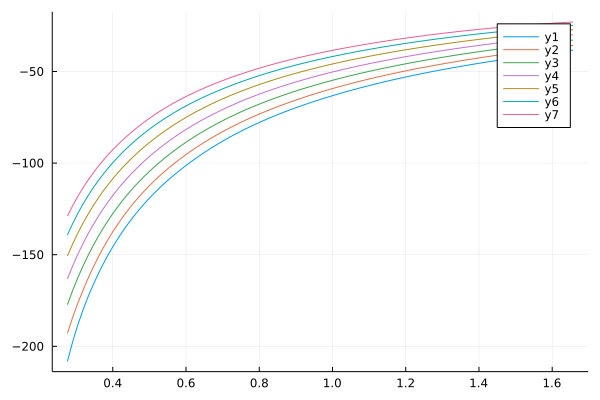

In [46]:
plot(k_grid, [V_store[1,:] V_store[2,:] V_store[3,:] V_store[4,:] V_store[5,:] V_store[6,:] V_store[7,:]])

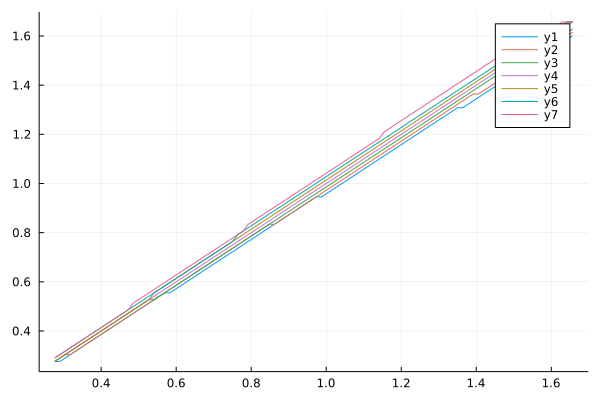

In [47]:
plot(k_grid, [k_grid[Int.(policy_index[1,:]),:] k_grid[Int.(policy_index[2,:]),:] k_grid[Int.(policy_index[3,:]),:] k_grid[Int.(policy_index[4,:]),:] k_grid[Int.(policy_index[5,:]),:] k_grid[Int.(policy_index[6,:]),:] k_grid[Int.(policy_index[7,:]),:]])

In [48]:
states_sim, states_idx_sim = mc_states(1, 1000, z_grid, k_grid, pi_matrix)

([0.9502491778486131 0.9502491778486131 … 0.9831335136374588 1.0], [1.0 1.0 … 3.0 4.0])

In [49]:
function sim_var_data(tech_state, tech_index, T=1000)

    capital_path_index_sim = ones(T+1)
    
    
    # What we want
    assets_sim = zeros(T+1)
    labour_sim = zeros(T+1)
    prod_sim = zeros(T+1)
    cons_sim = zeros(T+1)
    inv_sim = zeros(T+1)
    
    # Find capital accumulation
    for t in 1:T
        # Find appropriate index of the policy function
        capital_path_index_sim[t+1] = policy_index[Int.(tech_index[t]), Int.(capital_path_index_sim[t])]
        # Find grid point associated with the grid
        assets_sim[t] = k_grid[Int.(capital_path_index_sim[t+1])]
        labour_sim[t] = nstar(tech_state[t], assets_sim[t])
        prod_sim[t] = prod(tech_state[t], assets_sim[t], labour_sim[t])
    end

    for t in 1:T
        cons_sim[t] = cons(tech_state[t], assets_sim[t], assets_sim[t+1], labour_sim[t])
        inv_sim[t] = prod_sim[t] - cons_sim[t]
    end
    
    return assets_sim, labour_sim, prod_sim, cons_sim, inv_sim
    
end

sim_var_data (generic function with 2 methods)

In [65]:
assets_sim, labour_sim, prod_sim, cons_sim, inv_sim = sim_var_data(states_sim, states_idx_sim);

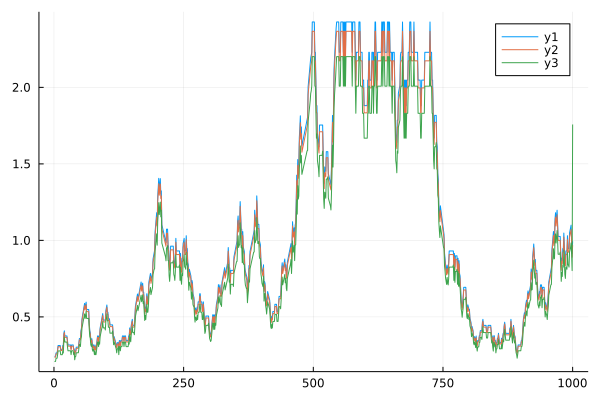

In [61]:
plot([labour_sim[1:end-1], prod_sim[1:end-1], cons_sim[1:end-1]])

---
## Step 2

In [64]:
function criterion(sim_moments, data_moments, W)
    
    criterion = ((sim_moments - data_moments)' * W * (sim_moments - data_moments))[1]

    return criterion
    
end

criterion (generic function with 1 method)

In [135]:
# formulate a grid around the two leftover parameters gamma and beta

@time begin
#Random.seed!(1235)    
beta_grid = LinRange(0.2, 1, 3)
gamma_grid = LinRange(0.5, 5, 3)
#total_comb = length(beta_grid), length(gamma_grid)
#dist = zeros(length(beta_grid)*length(gamma_grid), 3)
#dist[:,1] = repeat(1:length(beta_grid), length(gamma_grid))
#dist = sort(dist, dims=1)
#dist[:,2] = repeat(1:length(gamma_grid), length(gamma_grid))

data_moments = [0.83, 0.27]
    
#means = zeros(length(beta),S)
#vars = zeros(length(beta),S)

S = 2
opt_beta = zeros(S)    
opt_gamma = zeros(S)
    
for s in 1:S
    
    seed_ = 1234 + s
    Random.seed!(seed_)    

    iter_beta_grid = 1
    mean_sim = zeros(length(beta_grid)*length(gamma_grid))
    var_sim = zeros(length(beta_grid)*length(gamma_grid))
    sim_moments = []
    dist = zeros(length(beta_grid)*length(gamma_grid), 3)
    dist[:,1] = repeat(1:length(beta_grid), length(gamma_grid))
    dist = sort(dist, dims=1)
    dist[:,2] = repeat(1:length(gamma_grid), length(gamma_grid))
        
    for i in 1:length(beta_grid)
        beta_now = beta_grid[i]
        println("We are at $i for beta")

        for j in 1:length(gamma_grid)
            gamma_now = gamma_grid[j]

            labour_store_var, util_store_var = labour_decision(k_grid, z_grid, gamma_now);
            V_store_var, policy_index_var, iter_var = value_fun_it(beta_now, k_grid, z_grid, pi_matrix, util_store);
            states_sim_var, states_idx_sim_var = mc_states(1, 1000, z_grid, k_grid, pi_matrix);
            assets_sim_var, labour_sim_var, prod_sim_var, cons_sim_var, inv_sim_var = sim_var_data(states_sim_var, states_idx_sim_var);

            mean_sim[iter_beta_grid] = mean(assets_sim_var)
            var_sim[iter_beta_grid] = var(assets_sim_var)
            sim_moments = vec([mean_sim[iter_beta_grid] var_sim[iter_beta_grid]])

            dist[iter_beta_grid,3] = criterion(sim_moments, data_moments, Matrix(1.0I, length(sim_moments), length(sim_moments)));
            iter_sim = iter_sim +1;

        end
    end
    min_idx = argmin(dist[:,3])
    opt_beta[s], opt_gamma[s] = beta_grid[Int.(dist[min_idx,:][1])], gamma_grid[Int.(dist[min_idx,:][2])]
end

end

We are at 1 for beta
We are at 2 for beta
We are at 3 for beta
We are at 1 for beta
We are at 2 for beta
We are at 3 for beta
222.457263 seconds (843.80 M allocations: 134.435 GiB, 9.66% gc time, 0.00% compilation time)


In [137]:
opt_beta, opt_gamma

([0.2, 0.2], [2.75, 2.75])

In [126]:
min_idx = argmin(dist[:,3])

dist[min_idx,:]

3-element Vector{Float64}:
  8.0
 10.0
  0.6294864996478795

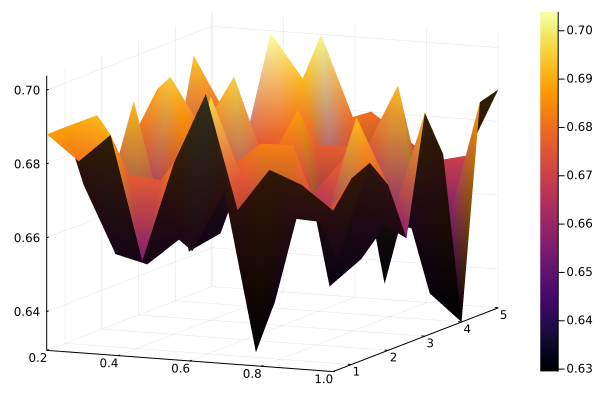

In [127]:
surface(beta_grid, gamma_grid, dist[:,3])

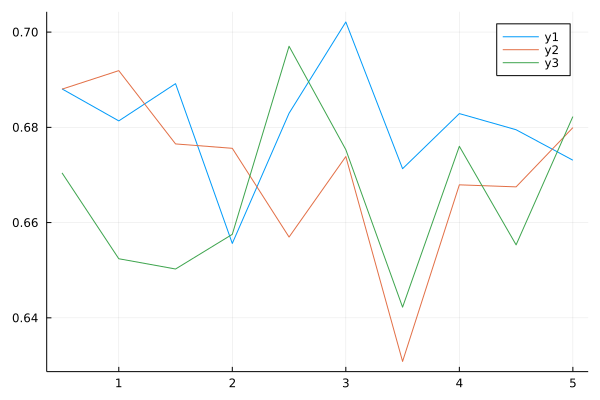

In [131]:
plot(gamma_grid, [dist[1:10,3] dist[11:20,3] dist[21:30,3]])

In [27]:
# Given the true parameters the SMM seems to be a good fit for beta. Gamma seems quite far off.